Lectura de datos.cvs

Analisis exploratorio de datos

In [ ]:
!pip install -qq contractions
!pip install -qq autocorrect
!pip install multidict
!pip install -qq ipython-autotime
!pip install -qq -U scikit-learn

     |████████████████████████████████| 321 kB 6.0 MB/s 
     |████████████████████████████████| 284 kB 29.7 MB/s 
     |████████████████████████████████| 622 kB 5.3 MB/s 
     |████████████████████████████████| 160 kB 5.1 MB/s 


In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from spacy.attrs import POS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

---
# **<font color='green'>Carga de archivo cvs</font>**
---


In [ ]:
%matplotlib inline
%load_ext autotime

time: 128 µs (started: 2021-12-06 14:46:20 +00:00)


In [ ]:
#@title Selección de carga de archivo cvs
descargar = "desde URL" #@param ["desde URL","localmente"]


time: 1.02 ms (started: 2021-12-06 14:46:23 +00:00)


In [ ]:
# es el cvs con las busquedas en scopus de 700 papers sobre robotica y simuladores con algunos ya clasificados
url = 'https://raw.githubusercontent.com/NestorBalich/IA-ML/main/700_papers_scopus.cvs'
dfaux = pd.read_csv(url, encoding='latin-1', sep=',')
print("Cantidad de columnas: ",len(dfaux.columns))
print("Cantidad de filas: ",len(dfaux))

Cantidad de columnas:  36
Cantidad de filas:  700
time: 325 ms (started: 2021-12-06 14:46:25 +00:00)


---
# **<font color='green'>Primer selección de features</font>**
---

In [ ]:
# Estos son los features del dataset
dfaux.columns

Index(['eid', 'doi', 'pii', 'pubmed_id', 'title', 'subtype',
       'subtypeDescription', 'creator', 'afid', 'affilname',
       'affiliation_city', 'affiliation_country', 'author_count',
       'author_names', 'author_ids', 'author_afids', 'coverDate',
       'coverDisplayDate', 'publicationName', 'issn', 'source_id', 'eIssn',
       'aggregationType', 'volume', 'issueIdentifier', 'article_number',
       'pageRange', 'description', 'authkeywords', 'citedby_count',
       'openaccess', 'fund_acr', 'fund_no', 'fund_sponsor', 'abstract',
       'include?'],
      dtype='object')

time: 5.3 ms (started: 2021-12-06 14:46:29 +00:00)


---
## **<font color='blue'>Buscamos y eliminamos columnas sin datos</font>**
---

In [ ]:
#vemos si hay columnas que contengan todos null
dfaux.isna().sum()

eid                      0
doi                      0
pii                    585
pubmed_id              671
title                    0
subtype                  0
subtypeDescription       0
creator                  0
afid                   700
affilname                5
affiliation_city         7
affiliation_country      5
author_count           700
author_names           700
author_ids             700
author_afids           700
coverDate                0
coverDisplayDate         0
publicationName          0
issn                   140
source_id                0
eIssn                  244
aggregationType          0
volume                  32
issueIdentifier        192
article_number         431
pageRange              168
description            700
authkeywords           700
citedby_count            0
openaccess               0
fund_acr               700
fund_no                700
fund_sponsor           700
abstract                35
include?                 0
dtype: int64

time: 12.1 ms (started: 2021-12-06 14:46:33 +00:00)


In [ ]:
#eliminamos las columnas que tengan todos null
#en el set que estamos usando de ejemplo, no hay ninguna

feature_na = dfaux.isna().sum()
rows = len(dfaux)
df1 = dfaux.copy()
print("Borramos columnas con todos na")
for col in feature_na.index:
  if (rows == feature_na[col] ):
      print( " ", col)
      df1.drop(col, axis='columns', inplace=True)



Borramos columnas con todos na
  afid
  author_count
  author_names
  author_ids
  author_afids
  description
  authkeywords
  fund_acr
  fund_no
  fund_sponsor
time: 43 ms (started: 2021-12-06 14:46:36 +00:00)


---
## **<font color='blue'>Evaluamos y eliminamos columnas que no usaremos</font>**
---

In [ ]:
from google.colab import data_table

%load_ext google.colab.data_table 
data_table.enable_dataframe_formatter()
data_table.DataTable(df1, include_index=False, num_rows_per_page=10)
df1

,eid,doi,pii,pubmed_id,title,subtype,subtypeDescription,creator,affilname,affiliation_city,affiliation_country,coverDate,coverDisplayDate,publicationName,issn,source_id,eIssn,aggregationType,volume,issueIdentifier,article_number,pageRange,citedby_count,openaccess,abstract,include?
0,2-s2.0-84872723602,10.5755/j01.eee.18.9.2825,NaN,NaN,The LEGO NXT robot-based e-learning environmen...,ar,Article,Burbaite R.,Kaunas University of Technology,Kaunas,Lithuania,2012-12-01,2012,Elektronika ir Elektrotechnika,13921215,19900193212,NaN,Journal,18,9,NaN,113-116,12,1,It is difficult to motivate learners to learn ...,SI
1,2-s2.0-84870861362,10.1080/03043797.2012.725711,NaN,NaN,Embedded C programming: A practical course int...,ar,Article,Laverty D.,Queen's University Belfast,Belfast,United Kingdom,2012-12-01,December 2012,European Journal of Engineering Education,03043797,11300153314,14695898,Journal,37,6,NaN,557-574,3,0,This paper presents a new laboratory-based mod...,NO
2,2-s2.0-84864477631,10.1016/j.eswa.2012.04.038,S0957417412006355,NaN,Adaptability analysis of genetic network progr...,ar,Article,Mabu S.,Waseda University,Tokyo,Japan,2012-11-15,15 November 2012,Expert Systems with Applications,09574174,24201,NaN,Journal,39,16,NaN,12349-12357,10,0,Genetic network programming (GNP) has been pro...,NO
3,2-s2.0-84866405210,10.1080/01691864.2012.703167,NaN,NaN,Learning manipulation tasks from human demonst...,ar,Article,Aleotti J.,UniversitÃ di Parma,Parma,Italy,2012-11-01,1 November 2012,Advanced Robotics,01691864,18003,15685535,Journal,26,16,NaN,1863-1884,5,0,"According to neuro-psychology studies, 3D shap...",NO
4,2-s2.0-84868030296,10.5772/50827,NaN,NaN,Combining vision learning and interaction for ...,ar,Article,Bao J.,Yangzhou University;Southeast University,Yangzhou;Nanjing,China;China,2012-10-04,4 October 2012,International Journal of Advanced Robotic Systems,17298806,144749,17298814,Journal,9,NaN,104,NaN,5,1,This paper addresses the question of how to ma...,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2-s2.0-85094140525,10.1109/TASE.2020.2984739,NaN,NaN,A Method Integrating Q-Learning with Approxima...,ar,Article,Ou X.,Stony Brook University,Stony Brook,United States,2021-01-01,January 2021,IEEE Transactions on Automation Science and En...,15455955,17340,15583783,Journal,18,1,9069276,85-93,6,0,This article formulates gantry real-time sched...,NO
696,2-s2.0-85091727135,10.1007/s10514-020-09947-4,NaN,NaN,Reinforcement based mobile robot path planning...,ar,Article,Chang L.,Nanjing University of Science and Technology,Nanjing,China,2021-01-01,January 2021,Autonomous Robots,09295593,18016,15737527,Journal,45,1,NaN,51-76,8,0,Mobile robot path planning in an unknown envir...,NO
697,2-s2.0-85083969396,10.1002/cae.22245,NaN,NaN,Development of an augmented reality-based scaf...,ar,Article,Kumar A.,"Chitkara University, Punjab",Rajpura,India,2021-01-01,January 2021,Computer Applications in Engineering Education,10613773,18156,10990542,Journal,29,1,NaN,244-257,4,0,The Embedded system is the core unit of every ...,NO
698,2-s2.0-85068542094,10.1080/07370024.2019.1621175,NaN,NaN,Physical Programming for Blind and Low Vision ...,ar,Article,Morrison C.,Microsoft Research,Redmond,United States,2021-01-01,2021,Human-Computer Interaction,07370024,25019,NaN,Journal,36,5-6,NaN,535-569,3,0,There is a dearth of appropriate tools for you...,NO


time: 74.7 ms (started: 2021-12-06 14:46:40 +00:00)


In [ ]:
# Describiremos cada feature y decidiremos si la conservamos o no
# doi: el doi es un identificador de un documento electrónico. No aporta información relacionada con 
# nuestro target
df1.drop('doi', axis='columns', inplace=True) 

# pubmed_id: es un identificador especial de las publicaciones médicas. Puede ser relevante dado que
# define una categoría de pertenencia de la publicación que puede tener vínculo con nuestro target

# title: título de la publicación. Lo tokenizaremos para obtener los stems correspondientes. Entendemos
# que tiene una fuerte correlación con la pertinencia o no del paper al campo de búsqueda

# subtype: abreviatura de subtype description
# subtypeDescription: indica si es un artículo, review, conference, errata u otro. Vamos a conservar
# subtype dado que representan lo mismo
df1.drop('subtypeDescription', axis='columns', inplace=True)   

# creator: primer autor del artículo. Es altamente probable que un mismo autor escriba artículos de un
# mismo campo de estudio, y por lo tanto, esté correlacionado con la pertinencia

# affilname: institución del primer autor. También es probable que en una misma institución se desarrollen
# varios artículos sobre el mismo tema.

# affiliation_city: ciudad de la institución. No consideramos que aporte para la clasificación
# affiliation_country: país de la institución. Idem anterior.
df1.drop('affiliation_city', axis='columns', inplace=True)   
df1.drop('affiliation_country', axis='columns', inplace=True)   

# publicationName: nombre de la publicación del artículo. Entendemos que hay una correlación entre la
# publicación y la pertinencia o no de sus artículos para nuestra investigación.

# aggregationType: journal, Book, etc. También consideramos que puede tener alguna correlación
# de la misma forma que subtype.

# volume: número de volumen en la colección. Sin correlación. 
df1.drop('volume', axis='columns', inplace=True)   

# pageRange: si está publicado en un libro o revista, cuáles son los nros de páginas dentro de la
# publicación. No aporta a la pertinencia.
df1.drop('pageRange', axis='columns', inplace=True)   

# citedby_count: cantidad de citas. A pesar de que puede ser interesante para determinar calidad del
# artículo, no se relaciona con nuestro feature destino.
df1.drop('citedby_count', axis='columns', inplace=True)   

# abstract: del artículo. Junto con el título, consideramos que son los features que más aportarán a
# la creación del modelo

# include?: pertinencia o no del artículo a mi mapeo. Target feature.


time: 27.1 ms (started: 2021-12-06 14:46:47 +00:00)


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   eid               700 non-null    object 
 1   pii               115 non-null    object 
 2   pubmed_id         29 non-null     float64
 3   title             700 non-null    object 
 4   subtype           700 non-null    object 
 5   creator           700 non-null    object 
 6   affilname         695 non-null    object 
 7   coverDate         700 non-null    object 
 8   coverDisplayDate  700 non-null    object 
 9   publicationName   700 non-null    object 
 10  issn              560 non-null    object 
 11  source_id         700 non-null    int64  
 12  eIssn             456 non-null    object 
 13  aggregationType   700 non-null    object 
 14  issueIdentifier   508 non-null    object 
 15  article_number    269 non-null    object 
 16  openaccess        700 non-null    int64  
 1

---
# **<font color='green'>Normalización</font>**
---

---
## **<font color='blue'>Funciones de normalización</font>**
---


In [ ]:
#Declaracion de clase con comportamiento global

import re             # nos permite trabajar con expresiones regulares
import unicodedata    # para poder eliminar acentos y nomalizar a unicode
import numpy as np

import nltk
from nltk.tokenize.toktok import ToktokTokenizer # utilizada para las stopword
from nltk.tokenize import  word_tokenize # divide en tokens

nltk.download('stopwords')
nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk.download('punkt') # cargamos tokenizador

from bs4 import BeautifulSoup #agregamos para eliminar tags

nltk.download('wordnet')  #wordnet es una base de datos léxica para mas de 200 idiomas 
from nltk.stem import WordNetLemmatizer 

#lematizacion es cambiar la palabra por la de entrada en un diccionario
#ref: https://es.wikipedia.org/wiki/Lematizaci%C3%B3n#:~:text=La%20lematizaci%C3%B3n%20es%20un%20proceso,flexionadas%20de%20una%20misma%20palabra.
import spacy          # usamos de forma general para lematizar
nlp = spacy.load("en_core_web_sm") # carga el core para soporte de idiomas https://spacy.io/usage/models
                                   # se saca afuera de la función para mejorar el tiempo de lematización

import contractions
# Utilizamos autocorrect porque obtuvimos una mejor performance que spellchecker en nuestros tests
from autocorrect import Speller
from nltk.stem.snowball import SnowballStemmer

class Normalization:
  stemmer = SnowballStemmer(language='english')
  check = Speller(lang='en',fast=True)

  def __init__(self):
    pass

  @staticmethod
  def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmatized = ''
    for word in doc:
      if not word.lemma_.startswith('-') :
        lemmatized += word.lemma_ + ' '
        
    return lemmatized

  @staticmethod
  def stemmer_text_spacy(text):
    doc = nlp(text)
    stemmized=''
    for word in doc:
      stemmized += Normalization.stemmer.stem(word.text)+' '
    return stemmized.strip()

  @staticmethod
  def remove_stopwords(text,is_lower_case=False):
      tokens = ToktokTokenizer().tokenize(text)

      tokens = [token.strip() for token in tokens]
      if is_lower_case:
          filtered_tokens = [token for token in tokens if token not in nltk_stopwords]
      else:
          filtered_tokens = [token for token in tokens if token.lower() not in nltk_stopwords]
      filtered_text = ' '.join(filtered_tokens)
      return filtered_text

  @staticmethod
  def remove_special_characters(text, remove_digits=False):
      pattern = r'[՜^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
      text = re.sub(pattern, '', text)
      return text
  #para ver un caracte ren especial: chr(dic_frec_proc[''])

# Utilizamos autocorrect porque obtuvimos una mejor performance que spellchecker en nuestros tests
  @staticmethod
  def spell_check(text):
    return Normalization.check(text)

  @staticmethod
  def strip_html_tags(text):
      soup = BeautifulSoup(text, "html.parser")
      [s.extract() for s in soup(['iframe', 'script'])] # eliminamos los elementos de tipo iframe y script, si quisieramos recuperarlos y no solo borrarlos, deberíamos utilizar decompose
      stripped_text = soup.get_text()
      stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text) # reemplazamos secuencias de saltos de línea por uno solo
      return stripped_text

  @staticmethod
  def delete_black_word(texto):
    black_list = ["՜","RT"]
    splitText = texto.split()
    out = ' '.join([i for i in splitText if i not in black_list])
    return out

  @staticmethod
  def delete_not_white_char(texto):
    import re
    result = re.sub('[^a-zA-Z0-9]', '', texto)
    return out

      #remueve contenido especifico urls hashtag
  @staticmethod
  def remove_content(text):
      text = re.sub(r"http\S+", "", text) #remove urls
      text=re.sub(r'\S+\.com\S+','',text) #remove urls
      text=re.sub(r'\@\w+','',text) #remove mentions
      text =re.sub(r'\#\w+','',text) #remove hashtags
      return text

def normalizar_numeric(dataf,
                    n_feature,
                    n_exist,
                    n_view):
    
    n_proc_feature = "proc_" + n_feature
    ldataNorm = dataf.copy()
    ldataNorm.loc[:,n_proc_feature]=dataf.loc[:,n_feature]

    if (n_view ):
        print("\n=======================================") 
        print("* Nomalización de feature numeric: ",n_feature , " en ", n_proc_feature) 

    if n_exist: 
        if (n_view ):print("* Normaliza si existe valor 1 sino existe 0")
        ldataNorm[n_proc_feature]=ldataNorm[n_proc_feature].apply(lambda x: 1 if x>0 else 0)

    if (n_view ): print("=======================================") 

    return ldataNorm

def normalizar_text(dataf,
                    n_feature,
                    n_eliminar_rows_con_feature_nulo,
                    n_reemplazar_feature_nulo_por_unknow ,
                    n_eliminar_espacios_iniciales_finales ,
                    n_pasar_minuscula ,
                    n_eliminar_espacios ,
                    n_eliminar_stopwords,
                    n_expandir_contracciones,
                    n_eliminar_caracteres_especiales,
                    n_correccion_ortografica,
                    n_reemplar_doble_espacios,
                    n_eliminar_acentos,
                    n_elimina_tag,
                    n_elimina_menciones,
                    n_elimina_to_black_word_list,
                    n_elimina_sino_esta_en_white_char,
                    n_lemmatize_text_spacy,
                    n_stemmer_text_spacy,
                    n_view):

    n_proc_feature = "proc_" + n_feature 
    ldataNorm = dataf.copy()
    ldataNorm.loc[:,n_proc_feature]=dataf.loc[:,n_feature]

    if (n_view ):
        print("\n=======================================") 
        print("* Normalización de feature text: ",n_feature , " en ", n_proc_feature) 

    if n_eliminar_rows_con_feature_nulo:  
        nulos = ldataNorm[n_feature].isna().sum()
        if (n_view ):print("* Remover los rows con nulos, se removieron:", nulos)
        ldataNorm.drop(ldataNorm[ldataNorm[n_feature].isna()].index, inplace=True)

    if n_reemplazar_feature_nulo_por_unknow:  
      # Rellenar affilname nan con Unknown
      if (n_view ):print("* Reemplazar las columnas con nulos por unknown")
      ldataNorm[[n_proc_feature]] = ldataNorm[[n_proc_feature]].fillna(value='unknown')
    if n_eliminar_espacios_iniciales_finales:  
        if (n_view ):print("* Eliminamos los espacios iniciales y finales") 
        ldataNorm.loc[:,n_proc_feature] = ldataNorm.loc[:,n_proc_feature].str.strip()
    if n_pasar_minuscula:  
        if (n_view ):print("* Pasa palabras a minúsculas")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x : x.lower() )
    if n_eliminar_espacios:  
        if (n_view ):print("* Removemos espacios en blanco extras")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x:  re.sub(' +', ' ', x))
    if n_eliminar_stopwords: 
        if (n_view ):print("* Removemos las stopwords")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.remove_stopwords(x, True)) 
    if n_expandir_contracciones: 
        if (n_view ):print("* Expandimos las contracciones en ingles")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x: contractions.fix(x))
    if n_eliminar_caracteres_especiales:     
        if (n_view ):print("* Removemos los carácteres especiales")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.remove_special_characters(x, True))
    if n_correccion_ortografica:    
        if (n_view ):print("* Realizamos corrección ortográfica rapida en ingles")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x : Normalization.spell_check(x) )
    if n_reemplar_doble_espacios:    
        if (n_view ):print("* Reemplazamos los doble espacios por uno solo")
        ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].str.replace('  ', ' ')
    if n_lemmatize_text_spacy:    
        if (n_view ):print("* Lematizamos")
        ldataNorm.loc[:,n_proc_feature] = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.lemmatize_text_spacy(str(x)))
    if n_stemmer_text_spacy:    
        if (n_view ):print("* Stemizamos")
        ldataNorm.loc[:,n_proc_feature] = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.stemmer_text_spacy(str(x)))

    #remueve los acentos  //Ojo esta funcion pone en mayuscula la primer letra por eso la conversión a minúscula se hace a continuación en el último paso por seguridad
    if n_eliminar_acentos: 
      if (n_view ):print("* Removemos acentos")
      ldataNorm.loc[n_proc_feature] = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.remove_accented_chars(x))
    if n_elimina_tag: 
      if (n_view ):print("* Removemos los tags")
      ldataNorm.loc[:,n_proc_feature] = ldataNorm.loc[:,n_proc_feature].apply(lambda x:  Normalization.strip_html_tags(x))
    if n_elimina_menciones: 
      if (n_view ):print("* Removemos las menciones")
      ldataNorm.loc[:,n_proc_feature] = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.remove_content(x))
    if n_elimina_to_black_word_list: 
      if (n_view ):print("* Removemos las palabras que estan en lista negra")
      ldataNorm.loc[:,n_proc_feature] = ldataNorm.loc[:,n_proc_feature].apply(lambda x: Normalization.delete_black_word(x)) 
    if n_elimina_sino_esta_en_white_char: 
      if (n_view ):print("* Removemos los caracteres que no esten en lista blanca")
      ldataNorm.loc[:,n_proc_feature]  = ldataNorm.loc[:,n_proc_feature].apply(lambda x: re.sub('[^a-zA-Z0-9]+$', '', x))

    if (n_view ): print("=======================================") 

    return ldataNorm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
time: 3.16 s (started: 2021-12-06 14:47:04 +00:00)


---
## **<font color='blue'>Normalización de cada feature (configurable)</font>**
---

In [ ]:
#@title Normalización pubmed_id
n_feature = "pubmed_id" 
n_exist = True #@param {type:"boolean"}

df1 = normalizar_numeric(df1,n_feature,n_exist,True)

df1[['pubmed_id','proc_pubmed_id']].head(50)


* Nomalización de feature numeric:  pubmed_id  en  proc_pubmed_id
* Normaliza si existe valor 1 sino existe 0


,pubmed_id,proc_pubmed_id
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
5,NaN,0
6,NaN,0
7,NaN,0
8,NaN,0
9,NaN,0


time: 39 ms (started: 2021-12-06 14:47:15 +00:00)


In [ ]:
#@title Normalization (texto): abstract
n_feature = "abstract" 
n_eliminar_rows_con_feature_nulo = True #@param {type:"boolean"}
n_reemplazar_feature_nulo_por_unknown = False #@param {type:"boolean"}
n_eliminar_espacios_iniciales_finales = True #@param {type:"boolean"}
n_pasar_minuscula = True #@param {type:"boolean"}
n_eliminar_espacios = True #@param {type:"boolean"}
n_eliminar_stopwords = True #@param {type:"boolean"}
n_expandir_contracciones = True #@param {type:"boolean"}
n_eliminar_caracteres_especiales = True #@param {type:"boolean"}
n_correccion_ortografica = True #@param {type:"boolean"}
n_reemplar_doble_espacios = True #@param {type:"boolean"}
n_eliminar_acentos = False #@param {type:"boolean"}
n_elimina_tag = False #@param {type:"boolean"}
n_elimina_menciones = False #@param {type:"boolean"}
n_elimina_black_word_list = True #@param {type:"boolean"}
n_elimina_sino_esta_en_white_char_list = False #@param {type:"boolean"}
n_lemmatize_text_spacy = False #@param {type:"boolean"}
n_stemmer_text_spacy = True #@param {type:"boolean"}

df1 = normalizar_text(df1,n_feature, n_eliminar_rows_con_feature_nulo,
                n_reemplazar_feature_nulo_por_unknown ,
                n_eliminar_espacios_iniciales_finales ,
                n_pasar_minuscula ,
                n_eliminar_espacios ,
                n_eliminar_stopwords,
                n_expandir_contracciones,
                n_eliminar_caracteres_especiales,
                n_correccion_ortografica,
                n_reemplar_doble_espacios,
                n_eliminar_acentos,
                n_elimina_tag,
                n_elimina_menciones,
                n_elimina_black_word_list,
                n_elimina_sino_esta_en_white_char_list,
                n_lemmatize_text_spacy,
                n_stemmer_text_spacy,
                True)

df1[['abstract','proc_abstract']].head(1)


* Normalización de feature text:  abstract  en  proc_abstract
* Remover los rows con nulos, se removieron: 35
* Eliminamos los espacios iniciales y finales
* Pasa palabras a minúsculas
* Removemos espacios en blanco extras
* Removemos las stopwords
* Expandimos las contracciones en ingles
* Removemos los carácteres especiales
* Realizamos corrección ortográfica rapida en ingles
* Reemplazamos los doble espacios por uno solo
* Stemizamos
* Removemos las palabras que estan en lista negra


,abstract,proc_abstract
0,It is difficult to motivate learners to learn ...,difficult motiv learner learn abstract comput ...


time: 23.5 s (started: 2021-12-06 14:47:22 +00:00)


In [ ]:
#@title Normalización (texto): title
n_feature = "title" 
n_eliminar_rows_con_feature_nulo = False #@param {type:"boolean"}
n_reemplazar_feature_nulo_por_unknown = True #@param {type:"boolean"}
n_eliminar_espacios_iniciales_finales = True #@param {type:"boolean"}
n_pasar_minuscula = True #@param {type:"boolean"}
n_eliminar_espacios = True #@param {type:"boolean"}
n_eliminar_stopwords = True #@param {type:"boolean"}
n_expandir_contracciones = True #@param {type:"boolean"}
n_eliminar_caracteres_especiales = True #@param {type:"boolean"}
n_correccion_ortografica = True #@param {type:"boolean"}
n_reemplar_doble_espacios = True #@param {type:"boolean"}
n_eliminar_acentos = False #@param {type:"boolean"}
n_elimina_tag = False #@param {type:"boolean"}
n_elimina_menciones = False #@param {type:"boolean"}
n_elimina_black_word_list = False #@param {type:"boolean"}
n_elimina_sino_esta_en_white_char_list = False #@param {type:"boolean"}
n_lemmatize_text_spacy = False #@param {type:"boolean"}
n_stemmer_text_spacy = True #@param {type:"boolean"}

df1 = normalizar_text(df1,n_feature, n_eliminar_rows_con_feature_nulo,
                n_reemplazar_feature_nulo_por_unknown ,
                n_eliminar_espacios_iniciales_finales ,
                n_pasar_minuscula ,
                n_eliminar_espacios ,
                n_eliminar_stopwords,
                n_expandir_contracciones,
                n_eliminar_caracteres_especiales,
                n_correccion_ortografica,
                n_reemplar_doble_espacios,
                n_eliminar_acentos,
                n_elimina_tag,
                n_elimina_menciones,
                n_elimina_black_word_list,
                n_elimina_sino_esta_en_white_char_list,
                n_lemmatize_text_spacy,
                n_stemmer_text_spacy,
                True)

df1[['title','proc_title']].head(5)


* Normalización de feature text:  title  en  proc_title
* Reemplazar las columnas con nulos por unknown
* Eliminamos los espacios iniciales y finales
* Pasa palabras a minúsculas
* Removemos espacios en blanco extras
* Removemos las stopwords
* Expandimos las contracciones en ingles
* Removemos los carácteres especiales
* Realizamos corrección ortográfica rapida en ingles
* Reemplazamos los doble espacios por uno solo
* Stemizamos


,title,proc_title
0,The LEGO NXT robot-based e-learning environmen...,lego nxt robotbas learn environ teach comput s...
1,Embedded C programming: A practical course int...,embed c program practic cours introduc program...
2,Adaptability analysis of genetic network progr...,adapt analysi genet network program reinforc l...
3,Learning manipulation tasks from human demonst...,learn manipul task human demonstr d shape segment
4,Combining vision learning and interaction for ...,combin vision learn interact mobil robot path ...


time: 6.4 s (started: 2021-12-06 14:47:50 +00:00)


---
## **<font color='blue'>Gráficos para una primera visualización de title y abstract</font>**
---

In [ ]:
#ACAACA Ver optimización de estas funciones
from wordcloud import WordCloud
def wc_from_dict(word_count,title, file_name=""):
    wc = WordCloud(
        #max_words=40,  # Número máximo de palabras
        max_font_size = 200, # tamaño de fuente máximo
        background_color="white",  # Establecer el fondo en blanco, el valor predeterminado es negro
        width = 1500,  # Establecer el ancho de la imagen
        height= 960,  # Establecer la altura de la imagen
        margin= 10  # Establecer el borde de la imagen
    )
    wc.generate_from_frequencies(word_count)  # Generar nube de palabras del diccionario
    plt.figure(figsize = (15, 15), facecolor = None)
    plt.title(title)
    plt.imshow(wc)  # Mostrar nube de palabras
    plt.axis('off')  # Cerrar el eje
    plt.show()  # Mostrar imagen
    if file_name!="":
      wc.to_file(file_name)  # Guardar imagen

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
def generate_dict(df,feature,val_reverse):
    #creamos tag de todos lo feature
    card_docs = [TaggedDocument(doc.split(' '), [i]) 
                for i, doc in enumerate(df[feature])]

    #cargamos el diccionario y contamos frecuencia
    diccionario_frecuencias = {}
    #x = [" ", 0]
    for doc in card_docs:
      for words in doc:
        for word in words:
          palabra = str(word)
          if palabra in diccionario_frecuencias:
              diccionario_frecuencias[palabra] += 1
          else:
              diccionario_frecuencias[palabra] = 1
          
    #ordenamos descendente      
    from collections import OrderedDict
    sortedDict = OrderedDict(sorted(diccionario_frecuencias.items(), key=lambda x: x[1],reverse=val_reverse))

    return sortedDict

import matplotlib.pyplot as plt
def bar_from_dict(dic_frec, top, title, file_name=""):
    the_dict = {}
    count = 0
    for dic in dic_frec:
      the_dict[dic] = dic_frec[dic]
      
      count +=1
      if count > top:
        break

    x = list(the_dict.keys())
    y = list(the_dict.values())

    fig = plt.figure(figsize = (30, 15), facecolor = None)
    plt.rcParams.update({'font.size': 22})
    plt.title(title)
    plt.bar( x,y)
    plt.xlabel('word')
    plt.ylabel('count')
    plt.xticks(rotation=90)
    plt.show()
    if file_name!="":
      fig.savefig(file_name)  # Guardar imagen


time: 657 ms (started: 2021-12-06 14:48:26 +00:00)


---
### **<font color='black'>Titles</font>**
---

------------------------- Titles prenormalizados ----------------------------------------------------------


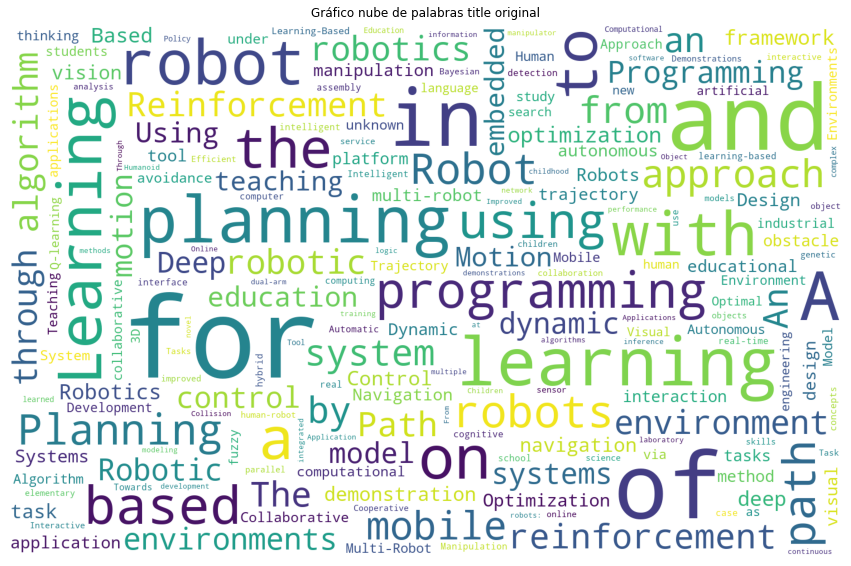

-------------------------- Titles normalizados y stematizados ---------------------------------------------


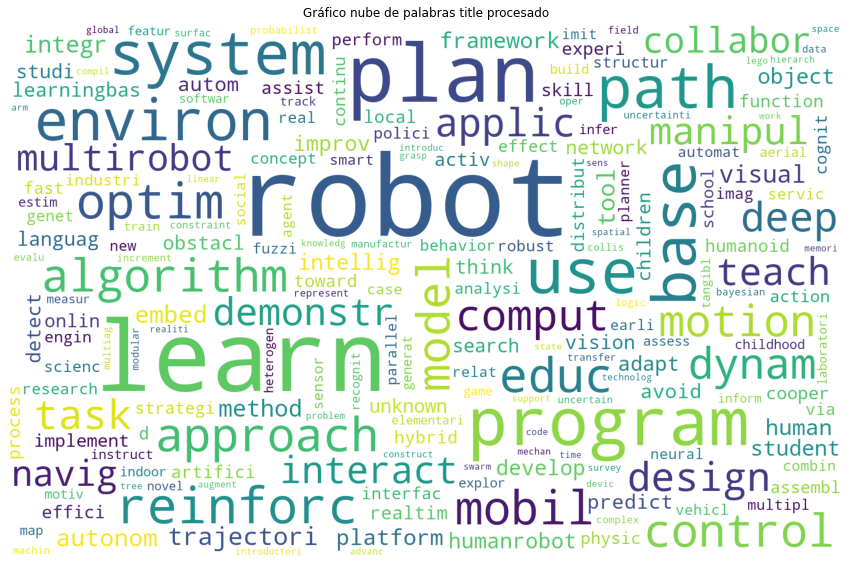

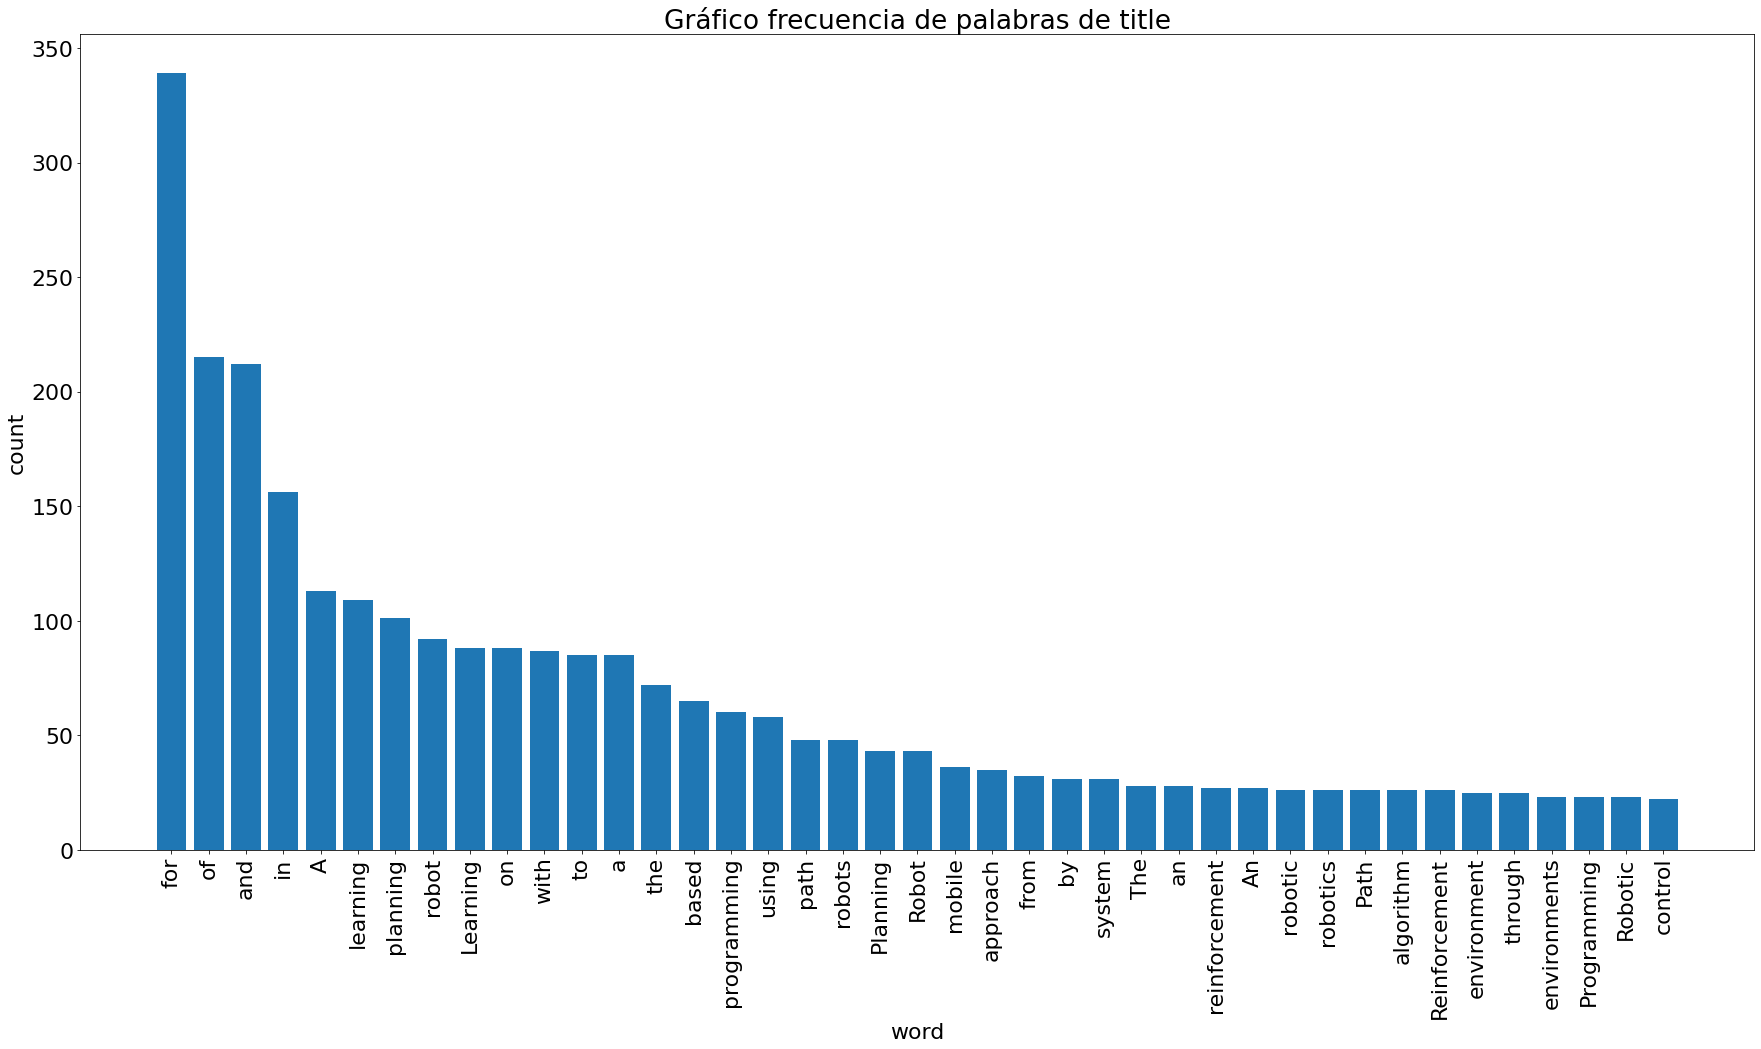

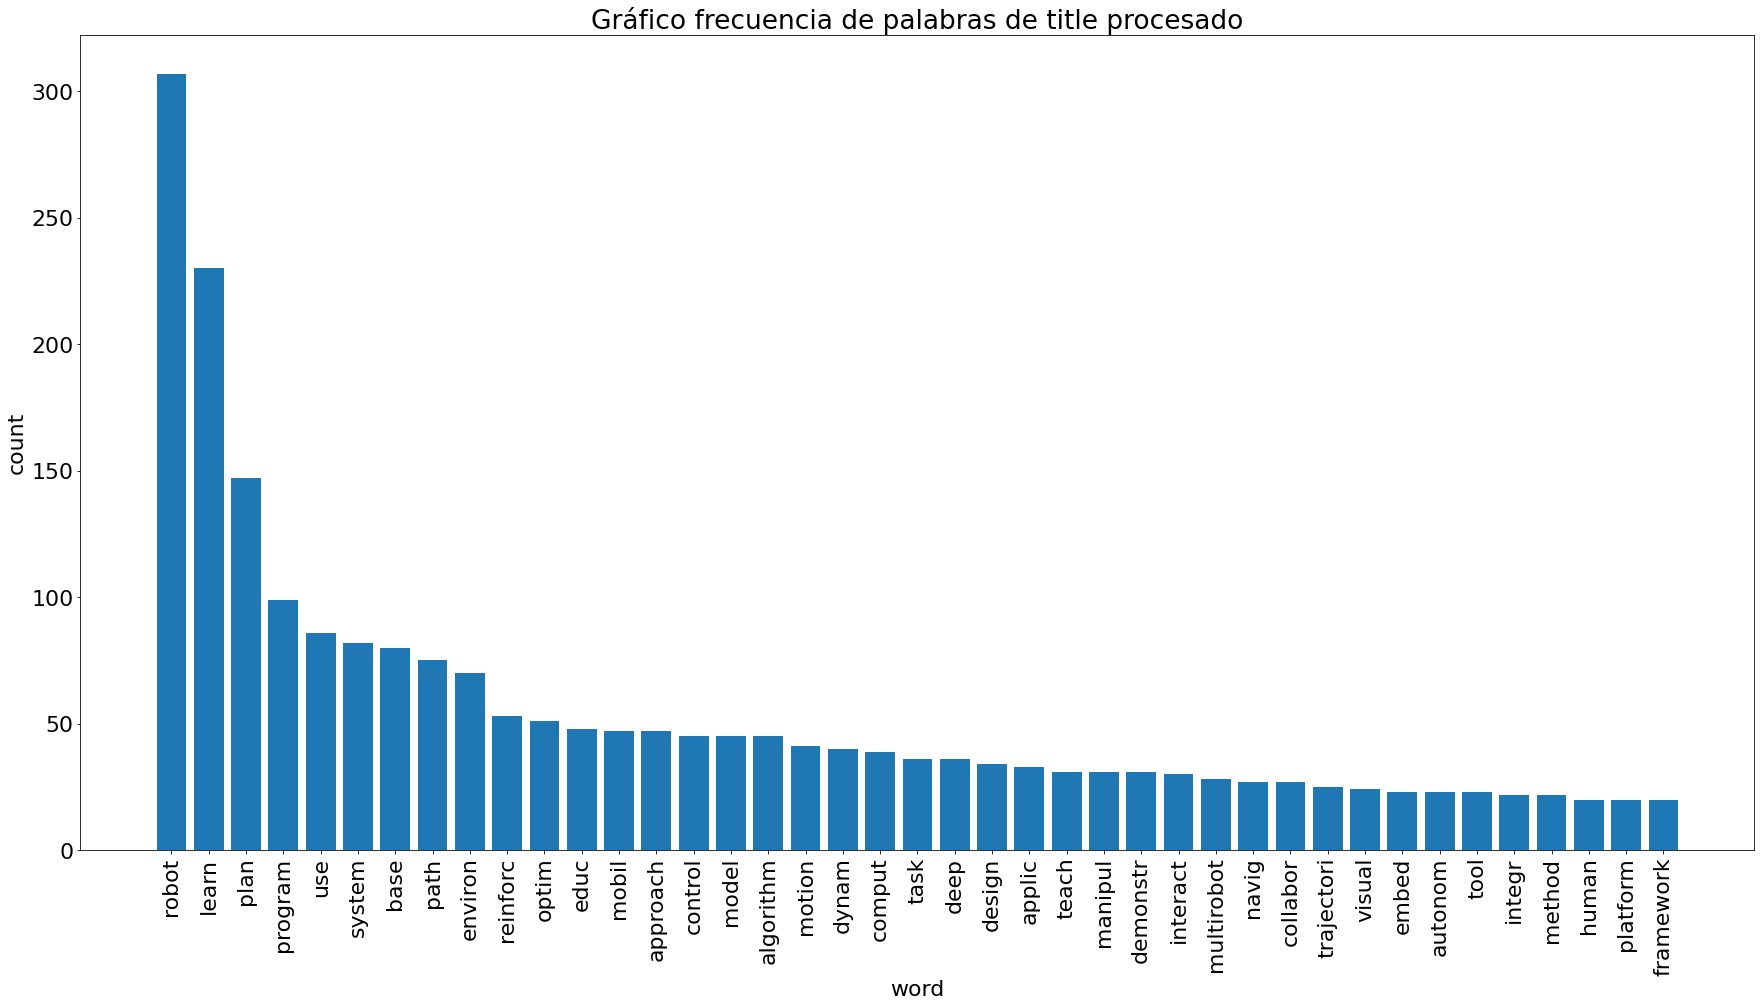

time: 8.02 s (started: 2021-12-06 14:48:32 +00:00)


In [ ]:

#creamos diccionario de palabras
dic_frec = generate_dict(df1,"title",True)

print('------------------------- Titles prenormalizados ----------------------------------------------------------')
wc_from_dict(dic_frec,"Gráfico nube de palabras title original")

print('-------------------------- Titles normalizados y stematizados ---------------------------------------------')
dic_frec_proc = generate_dict(df1,"proc_title",True)
wc_from_dict(dic_frec_proc,"Gráfico nube de palabras title procesado")


bar_from_dict(dic_frec, 40, "Gráfico frecuencia de palabras de title")
bar_from_dict(dic_frec_proc, 40, "Gráfico frecuencia de palabras de title procesado")


---
### **<font color='black'>Abstract</font>**
---

------------------------- Abstracts prenormalizados ----------------------------------------------------------


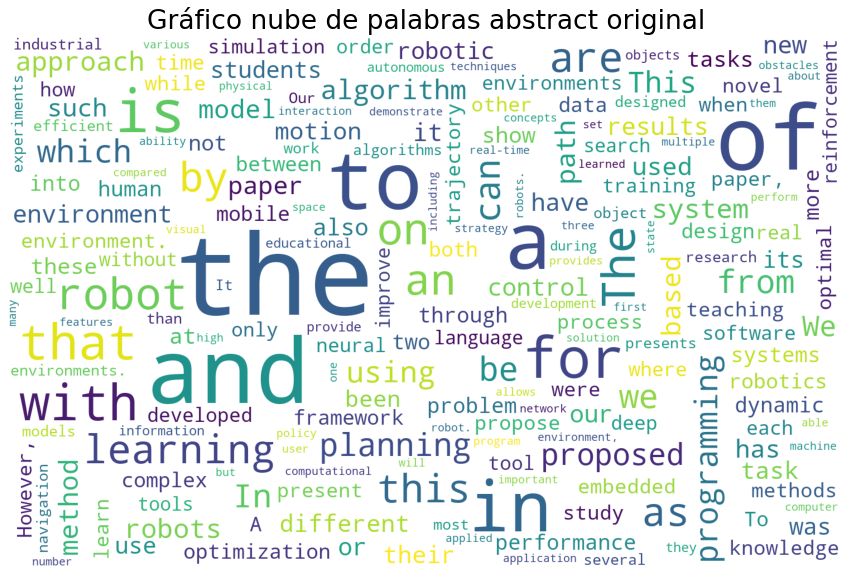

-------------------------- Abstracts normalizados y stematizados ---------------------------------------------


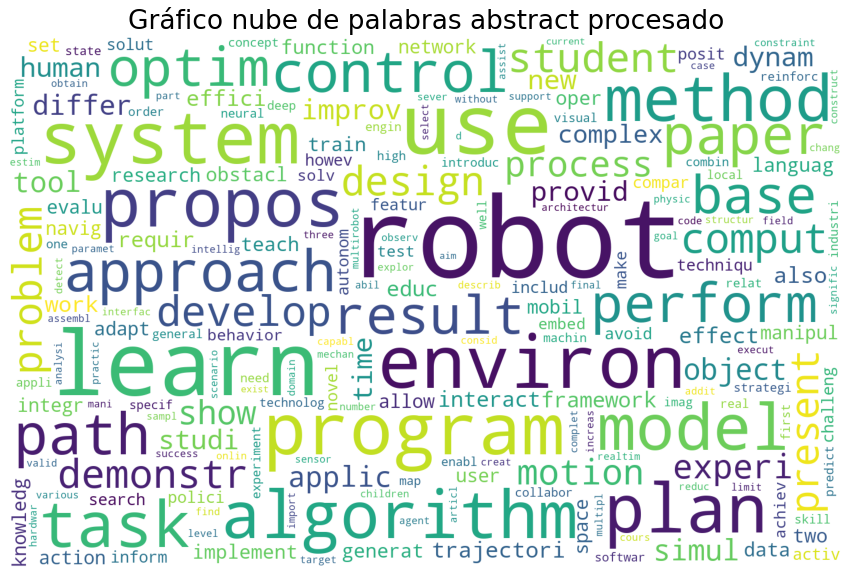

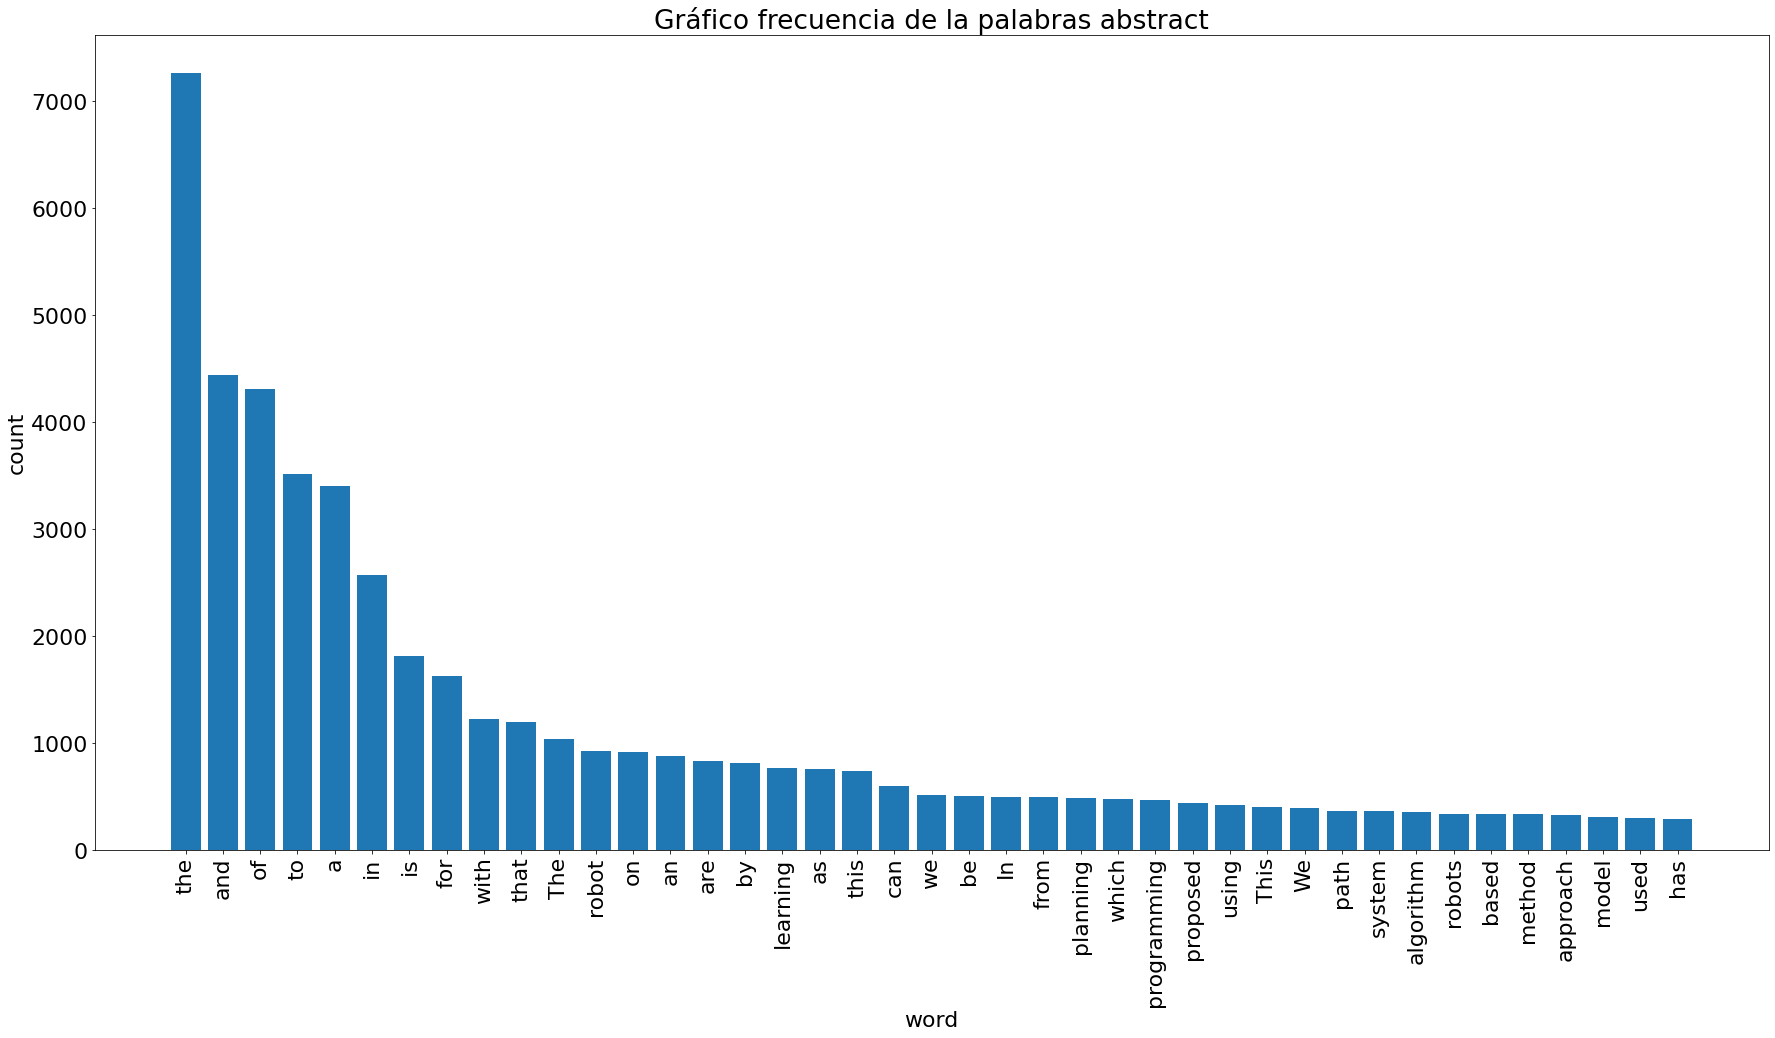

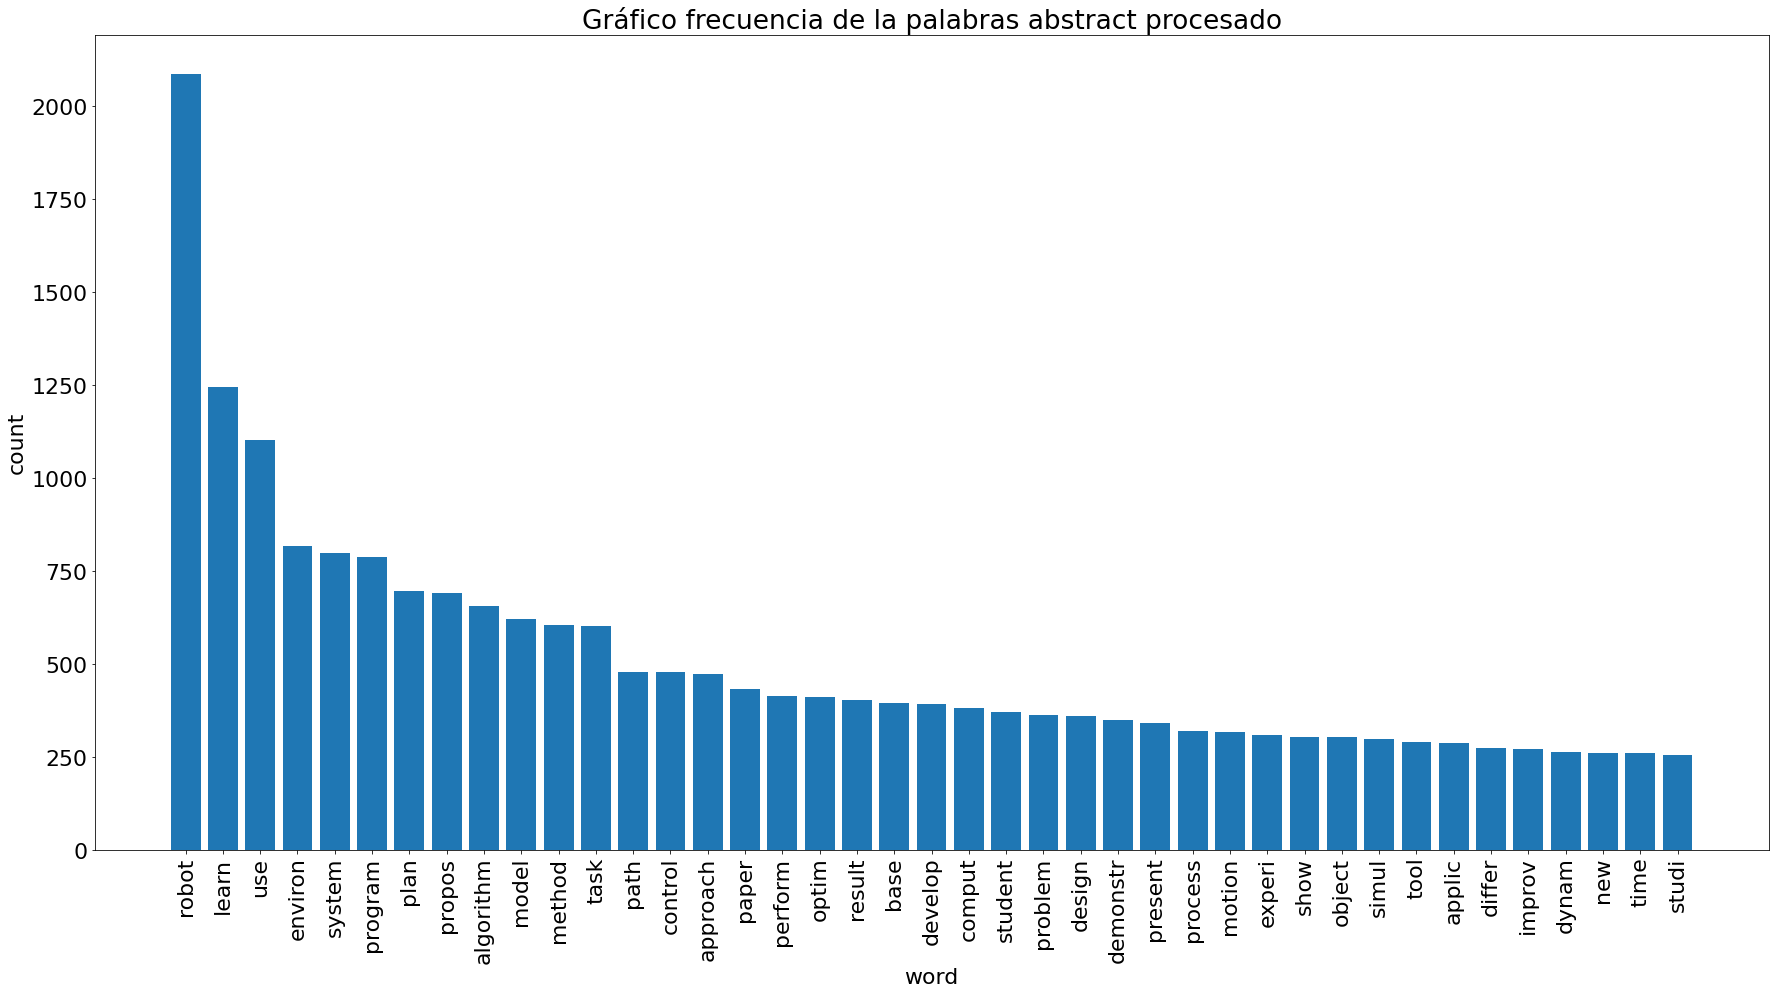

time: 8.82 s (started: 2021-12-06 14:48:52 +00:00)


In [ ]:
#creamos diccionario de palabras
dic_frec = generate_dict(df1,"abstract",True)

print('------------------------- Abstracts prenormalizados ----------------------------------------------------------')
wc_from_dict(dic_frec,"Gráfico nube de palabras abstract original")

print('-------------------------- Abstracts normalizados y stematizados ---------------------------------------------')
dic_frec_proc = generate_dict(df1,"proc_abstract",True)
wc_from_dict(dic_frec_proc,"Gráfico nube de palabras abstract procesado")

bar_from_dict(dic_frec, 40, "Gráfico frecuencia de la palabras abstract")
bar_from_dict(dic_frec_proc, 40, "Gráfico frecuencia de la palabras abstract procesado")


---
## **<font color='blue'>Borramos feature ya procesados</font>**
---

In [ ]:
#eliminamos los originales de las procesadas
df1.drop('title', axis='columns', inplace=True)
df1.drop('pubmed_id', axis='columns', inplace=True)
df1.drop('abstract', axis='columns', inplace=True)

time: 13.3 ms (started: 2021-12-06 14:49:00 +00:00)


---
# **<font color='green'>Preparacion del DataSet</font>**
---

In [ ]:
df1.columns

Index(['eid', 'pii', 'subtype', 'creator', 'affilname', 'coverDate',
       'coverDisplayDate', 'publicationName', 'issn', 'source_id', 'eIssn',
       'aggregationType', 'issueIdentifier', 'article_number', 'openaccess',
       'include?', 'proc_pubmed_id', 'proc_abstract', 'proc_title'],
      dtype='object')

time: 11.8 ms (started: 2021-12-06 14:49:01 +00:00)


In [ ]:
df1.replace({'include?': {'SI': 1, 'NO': 0}}, inplace=True)


time: 7.61 ms (started: 2021-12-06 14:49:03 +00:00)


In [ ]:
df1["text_to_proc"] = df1["creator"].map(str) + " " + df1["proc_title"].map(str) + " " + df1['proc_abstract'].map(str)\
 + " " + df1['subtype'].map(str)+" "+df1['affilname'].map(str)+" "+df1['publicationName'].map(str)+" "+df1['aggregationType'].map(str)+" "+df1['proc_pubmed_id'].map(str)

df1[["text_to_proc", "include?"]]

,text_to_proc,include?
0,Burbaite R. lego nxt robotbas learn environ te...,1
1,Laverty D. embed c program practic cours intro...,0
2,Mabu S. adapt analysi genet network program re...,0
3,Aleotti J. learn manipul task human demonstr d...,0
4,Bao J. combin vision learn interact mobil robo...,0
...,...,...
695,Ou X. method integr learn approxim dynam progr...,0
696,Chang L. reinforc base mobil robot path plan i...,0
697,Kumar A. develop augment realitybas scaffold i...,0
698,Morrison C. physic program blind low vision ch...,0


time: 90.7 ms (started: 2021-12-06 14:49:06 +00:00)


# Clusterizado

In [ ]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
 
 
def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    #text = text.translate(None, string.punctuation)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
 
 
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters, random_state=42)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering
 
 


time: 24.4 ms (started: 2021-12-06 14:50:33 +00:00)


## Unificación de feature

In [ ]:
df1["text_to_proc"] = df1["creator"].map(str) + " " + df1["proc_title"].map(str) + " " + df1['proc_abstract'].map(str)\
 + " " + df1['subtype'].map(str)+" "+df1['affilname'].map(str)+" "+df1['publicationName'].map(str)+" "+df1['aggregationType'].map(str)+" "+df1['proc_pubmed_id'].map(str)
#df1["text_to_proc"] = df1["creator"].map(str) + " " + df1["proc_title"].map(str) + " " + df1['proc_abstract'].map(str)+ " " + df1['subtype'].map(str)+" "+df1['affilname'].map(str)


time: 17.8 ms (started: 2021-12-06 14:51:24 +00:00)


## Clasterizado

In [ ]:
articles = df1['text_to_proc'].tolist()
numclust=2
clusters = cluster_texts(articles, numclust)
resu=dict(clusters)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


time: 2.93 s (started: 2021-12-06 14:51:58 +00:00)


In [ ]:
df1['include?'].value_counts()

0    580
1     85
Name: include?, dtype: int64

time: 7.74 ms (started: 2021-12-06 14:52:01 +00:00)


In [ ]:
for i in range(0,numclust):
  print(f"Cluster {i}")
  print(df1.iloc[resu[i]]['include?'].value_counts())

Cluster 0
0    127
1     85
Name: include?, dtype: int64
Cluster 1
0    453
Name: include?, dtype: int64
time: 8.9 ms (started: 2021-12-06 14:52:04 +00:00)


## Generar dataset desde el mejor claster


In [ ]:
clustSelected= 0 if (df1.iloc[resu[0]]['include?'].sum()>df1.iloc[resu[1]]['include?'].sum()) else 1
dfGuardado=df1.iloc[resu[clustSelected]]
# Nos guardamos el cluster completo donde cayeron los positivos
dfGuardado=dfGuardado[["text_to_proc", "include?"]]

time: 10.1 ms (started: 2021-12-06 14:53:06 +00:00)


## Guardado de los cvs procesados


In [ ]:
df1.shape

(665, 20)

time: 4.76 ms (started: 2021-12-06 14:54:44 +00:00)


In [ ]:
df1.to_csv("665_papers_eda_nomalizados.csv")

time: 54.7 ms (started: 2021-12-06 14:55:26 +00:00)


In [ ]:
dfGuardado.shape

(212, 2)

time: 3.92 ms (started: 2021-12-06 14:55:45 +00:00)


In [ ]:
dfGuardado.to_csv("212_papers_train_clasterizados.csv")

time: 14.6 ms (started: 2021-12-06 14:56:55 +00:00)
